In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
38846,NaN,NaN,International,2020-08-20,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38847,NaN,NaN,International,2020-08-21,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38848,NaN,NaN,International,2020-08-22,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


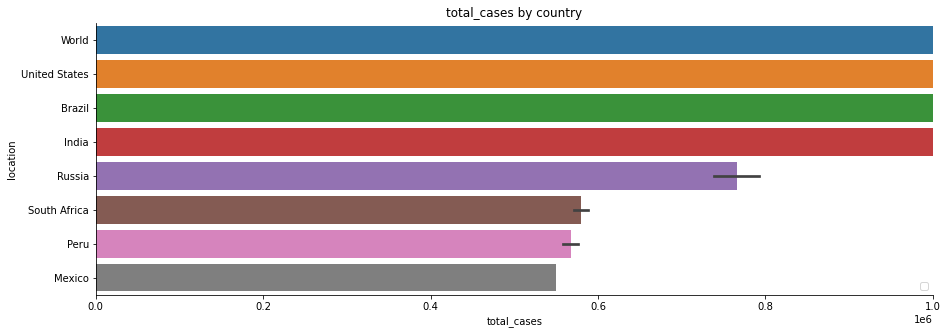

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


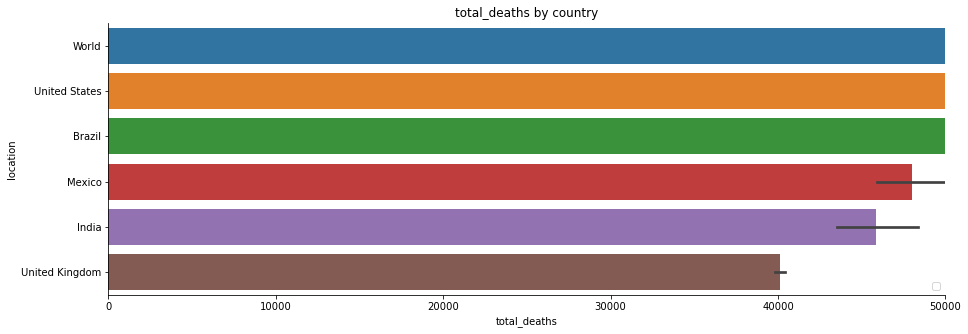

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


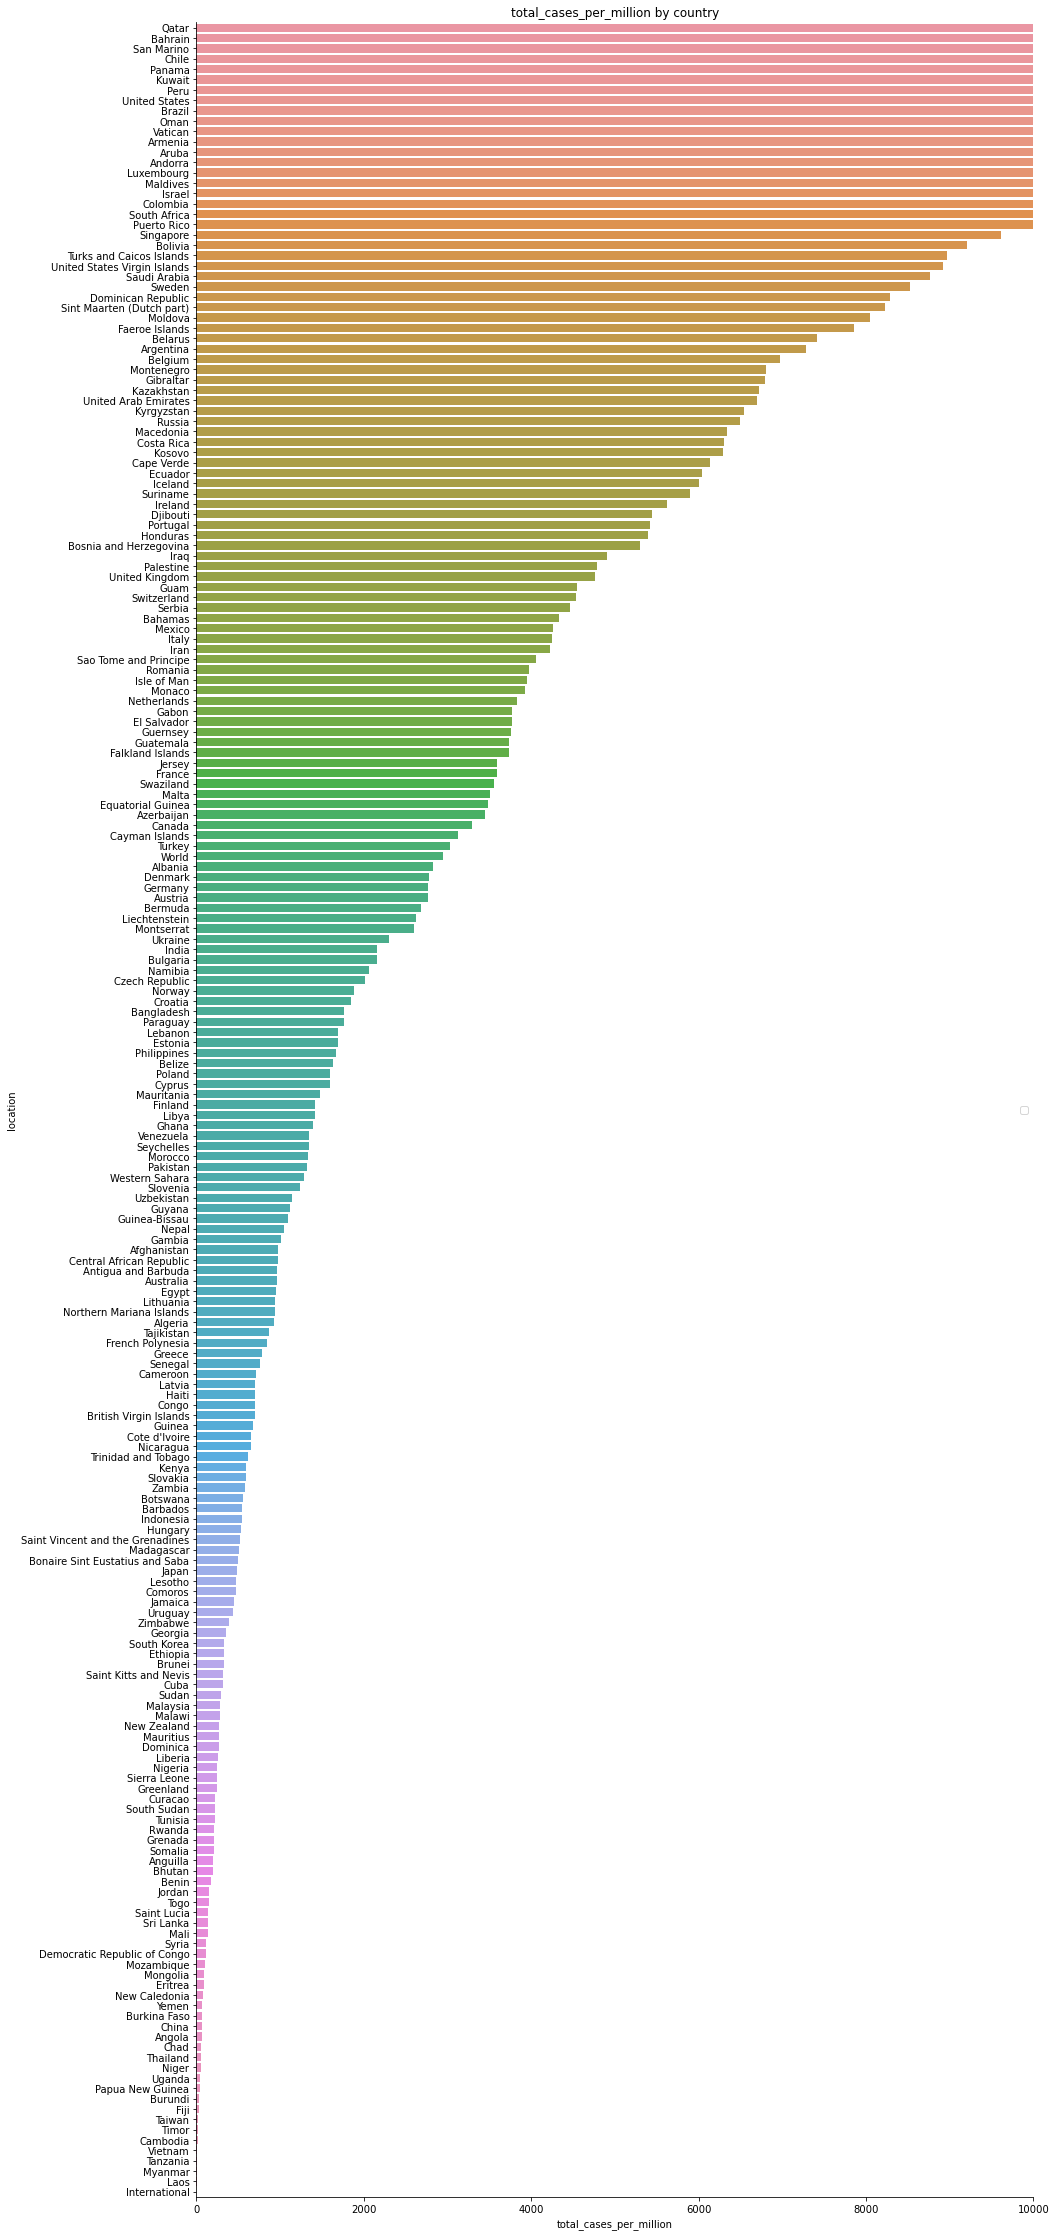

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


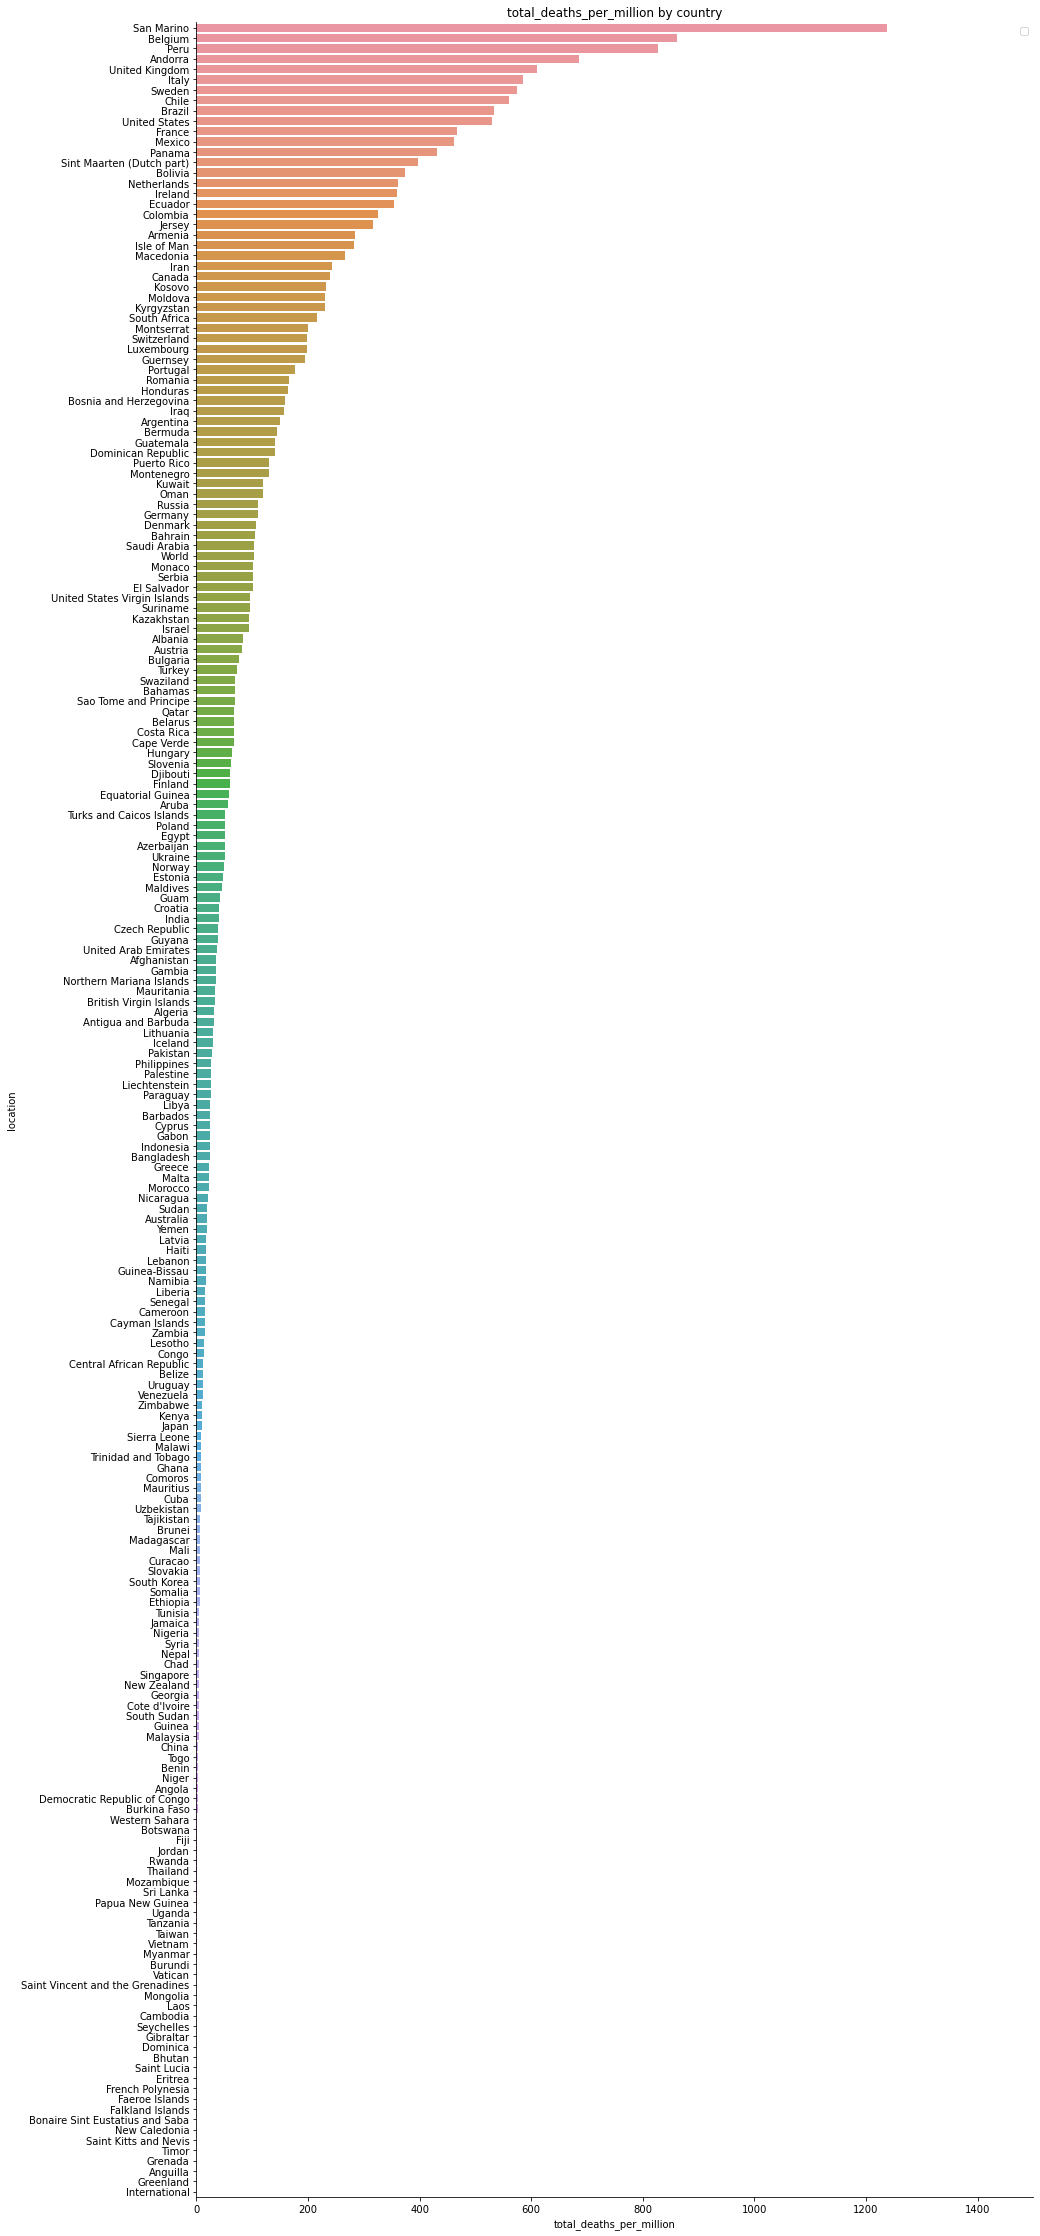

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

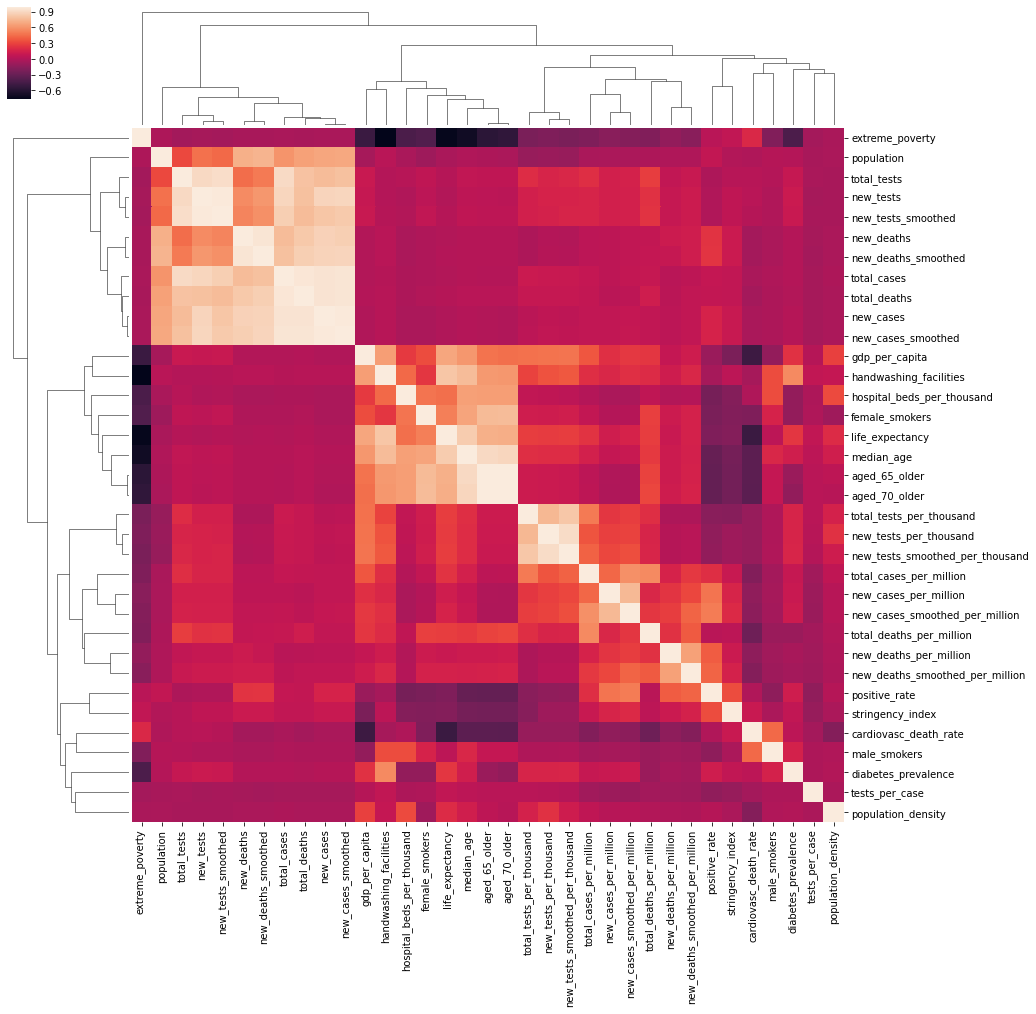

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995756938428061 (+/- 0.00023896937382433272)
Coef :  [1.04084260e+00 8.70893345e-05 9.16451184e-05]
3 Last_days :  [[22440361 22713807 22977399]]
Today :  22977399
Prediction + :  455348
Tomorow :  23432747
                                     
--------- Total Death -----------------
                                     
R^2: 0.999442096762071 (+/- 0.0002850711067907848)
Coef :  [-0.03950608  0.50735435  0.54230451]
3 Last_days :  [[787802 794138 800321]]
Today :  800321
Prediction + :  7745
Tomorow :  808066
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9720825594755418 (+/- 0.03139984152555673)
Coef :  [-0.67316665  0.72582466  0.94872078]
3 Last_days :  [[225043 229814 234400]]
Today :  234400
Prediction + :  3570
Tomorow :  237970
                                     
--------- Total Death -----------------
                                     
R^2: 0.39295072473849785 (+/- 0.8455821202322363)
Coef :  [-0.7543522   0.78847102  0.96497991]
3 Last_days :  [[30468 30480 30503]]
Today :  30503
Prediction + :  32
Tomorow :  30535
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.84214415673482 (+/- 0.11379828410311843)
Coef :  [-0.32262293 -0.02348278  1.34037752]
3 Last_days :  [[89527 89567 89616]]
Today :  89616
Prediction + :  44
Tomorow :  89660
                                     
--------- Total Death -----------------
                                     
R^2: -804.936603608834 (+/- 1139.5489839163206)
Coef :  [-0.07671969  0.01242768  1.05629722]
3 Last_days :  [[4706 4709 4711]]
Today :  4711
Prediction + :  7
Tomorow :  4718
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7596584947315955 (+/- 0.3385245020503296)
Coef :  [-0.83431811  0.90334156  0.93020135]
3 Last_days :  [[255278 256118 257065]]
Today :  257065
Prediction + :  810
Tomorow :  257875
                                     
--------- Total Death -----------------
                                     
R^2: 0.9019182319449693 (+/- 0.1125586336272646)
Coef :  [-0.83325628  0.90186969  0.93056466]
3 Last_days :  [[35412 35418 35427]]
Today :  35427
Prediction + :  27
Tomorow :  35454
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.738452739566808 (+/- 0.3598880445657462)
Coef :  [-0.70578051  0.58112942  1.12533425]
3 Last_days :  [[370867 377906 386054]]
Today :  386054
Prediction + :  6476
Tomorow :  392530
                                     
--------- Total Death -----------------
                                     
R^2: 0.238121206223781 (+/- 0.9017146913126075)
Coef :  [-0.71953558  0.61334918  1.1051908 ]
3 Last_days :  [[28797 28813 28838]]
Today :  28838
Prediction + :  23
Tomorow :  28861
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9973307209596259 (+/- 0.0034812228620234066)
Coef :  [0.07995932 0.46393232 0.47462504]
3 Last_days :  [[5529842 5573847 5623727]]
Today :  5623727
Prediction + :  85173
Tomorow :  5708900
                                     
--------- Total Death -----------------
                                     
R^2: 0.4733951281698415 (+/- 0.7433958380655887)
Coef :  [-0.60264844  0.75756573  0.84747454]
3 Last_days :  [[173177 174255 175406]]
Today :  175406
Prediction + :  1160
Tomorow :  176566
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9831695168452447 (+/- 0.022817003557207883)
Coef :  [-0.77280664  0.87292495  0.89997357]
3 Last_days :  [[321098 322280 323313]]
Today :  323313
Prediction + :  1287
Tomorow :  324600
                                     
--------- Total Death -----------------
                                     
R^2: 0.42852361263526645 (+/- 0.7795121939088212)
Coef :  [-0.77594806  0.83265021  0.94278332]
3 Last_days :  [[41397 41403 41405]]
Today :  41405
Prediction + :  43
Tomorow :  41448
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9803920188070628 (+/- 0.024458542576348944)
Coef :  [-0.81186281  0.86996734  0.94156066]
3 Last_days :  [[228621 228621 232082]]
Today :  232082
Prediction + :  15
Tomorow :  232097
                                     
--------- Total Death -----------------
                                     
R^2: 0.43090255092678004 (+/- 0.7922096204720883)
Coef :  [-0.79539676  0.84208182  0.95270543]
3 Last_days :  [[9253 9253 9267]]
Today :  9267
Prediction + :  6
Tomorow :  9273
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.046869688570693735 (+/- 1.3472270728958191)
Coef :  [0.18802913 0.41681437 0.40784327]
3 Last_days :  [[347835 352558 354764]]
Today :  354764
Prediction + :  3519
Tomorow :  358283
                                     
--------- Total Death -----------------
                                     
R^2: 0.8850223082935645 (+/- 0.16225878324388443)
Coef :  [-0.01480767  0.52567003  0.50295788]
3 Last_days :  [[19972 20264 20376]]
Today :  20376
Prediction + :  272
Tomorow :  20648
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9982467872447792 (+/- 0.0022201396690159836)
Coef :  [-0.75340201  0.85565034  0.89497187]
3 Last_days :  [[253108 254520 255723]]
Today :  255723
Prediction + :  1216
Tomorow :  256939
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991800208465128 (+/- 0.0008510570896117959)
Coef :  [-0.81938824  0.89881835  0.91756667]
3 Last_days :  [[6039 6058 6080]]
Today :  6080
Prediction + :  17
Tomorow :  6097
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4628090162203818 (+/- 0.756563442116572)
Coef :  [-0.17000799  0.49467108  0.69308418]
3 Last_days :  [[3456652 3501975 3532330]]
Today :  3532330
Prediction + :  65732
Tomorow :  3598062
                                     
--------- Total Death -----------------
                                     
R^2: 0.502876521806927 (+/- 0.6975482591681089)
Coef :  [-0.1655213   0.54045147  0.63848924]
3 Last_days :  [[111100 112304 113358]]
Today :  113358
Prediction + :  1547
Tomorow :  114905
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(22977399, 800321, 23432747, 808066),
 (234400, 30503, 237970, 30535),
 (257065, 35427, 257875, 35454),
 (386054, 28838, 392530, 28861),
 (5623727, 175406, 5708900, 176566),
 (89616, 4711, 89660, 4718),
 (323313, 41405, 324600, 41448),
 (232082, 9267, 232097, 9273),
 (354764, 20376, 358283, 20648),
 (255723, 6080, 256939, 6097),
 (3532330, 113358, 3598062, 114905)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-22,France,237970.0,0.0,30535.0,0.0,0.0,0.0
0,2020-08-22,China,89660.0,0.0,4718.0,0.0,0.0,0.0
0,2020-08-22,Italy,257875.0,0.0,35454.0,0.0,0.0,0.0
0,2020-08-22,Spain,392530.0,0.0,28861.0,0.0,0.0,0.0
0,2020-08-22,United States,5708900.0,0.0,176566.0,0.0,0.0,0.0
0,2020-08-22,World,23432747.0,0.0,808066.0,0.0,0.0,0.0
0,2020-08-22,United Kingdom,324600.0,0.0,41448.0,0.0,0.0,0.0
0,2020-08-22,Germany,232097.0,0.0,9273.0,0.0,0.0,0.0
0,2020-08-22,Iran,358283.0,0.0,20648.0,0.0,0.0,0.0
0,2020-08-22,Turkey,256939.0,0.0,6097.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")